# Create a User Defined Model using astropy.modeling

## Authors
Rocio Kiman, Lia Corrales and Zé Vinícius.

## Learning Goals
* Learn compound models
* Learn costume models
* Use the model to fit and to compare models (needs discussion)

## Keywords
Modeling, Fit, Costume Models, Compound Models 

## Summary
In this tutorial, we will learn how to define a new model in two ways: with a compound model and with a costume model.

### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model
from astropy.modeling import Fittable1DModel, Parameter

M dwarfs are low mass stars (Less than half of the mass of the sun). Currently we do not understand completely the physics inside low mass stars because they do not behave the same way higher mass stars do. For example, they stay magnetically active longer than higher mass stars. One way to measure magnetic activity is the height of the [$H\alpha$](https://en.wikipedia.org/wiki/H-alpha) emission line. It is located at $6563 (angstroms/to replace) $ at the spectrum. Let's search for a spectrum of an M dwarf in the Sloan Digital Sky Survey: [SDSS database](https://dr12.sdss.org/basicSpectra). SDSS has a particular way to identify the stars it observes: it uses three numbers: Plate, Fiber and MJD (Modified Julian Date). The star we are going to use has:
* Plate: 1349
* Fiber: 216
* MJD: 52797

So go ahead and download the fits file and save it in the same folder this tutorial is.

Once you are done, we can load the file by using the package `astropy.fits`.

In [3]:
spectrum = fits.open('spec-1349-52797-0216.fits')

One way to check what is inside the fits we just uploaded is the following:

In [5]:
spectrum[1].columns

ColDefs(
    name = 'flux'; format = 'E'
    name = 'loglam'; format = 'E'
    name = 'ivar'; format = 'E'
    name = 'and_mask'; format = 'J'
    name = 'or_mask'; format = 'J'
    name = 'wdisp'; format = 'E'
    name = 'sky'; format = 'E'
    name = 'model'; format = 'E'
)

To get the spectrum we need the flux of light as a function of the wavelength (usually called lambda or $\lambda$). Note that the wavelength is in log format: loglam, so we are going to calculate $10^\lambda$ to remove this scale.

In [8]:
flux = spectrum[1].data['flux']
lam = 10**(spectrum[1].data['loglam'])

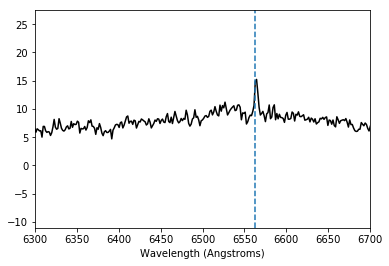

In [9]:
plt.plot(lam, flux, color='k')
plt.xlim(6300,6700)
plt.axvline(x=6563, linestyle='--')
plt.xlabel('Wavelength (Angstroms)')
plt.show()

We just plotted our spectrum! The blue dashed line marks the $H\alpha$ emission line. This is an active star because it has a high emission line.

Now, we would like to measure the height of this line. Let's use `astropy.modeling` to fit a gaussian to the $H\alpha$ line. We are going to initialize the gaussian at the position of the $H\alpha$ line to try catching the right one.

In [11]:
gg_init = models.Gaussian1D(1, 6563, 10)
fitter = fitting.LevMarLSQFitter()
gg_fit = fitter(gg_init, lam, flux)

Let's plot the results.

Text(0,0.5,'Flux')

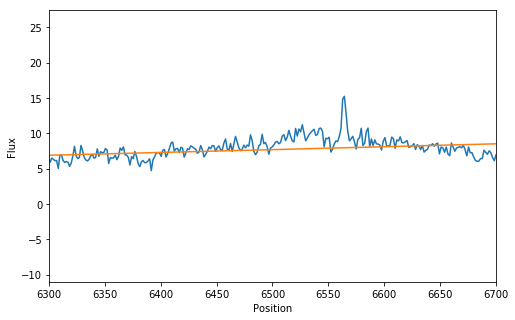

In [12]:
plt.figure(figsize=(8,5))
plt.plot(lam, flux)
plt.plot(lam, gg_fit(lam))
plt.xlim(6300,6700)
plt.xlabel('Position')
plt.ylabel('Flux')

We can see the fit is not doing a good work. Is it because of the fit we chose? Is it because of the range of data we are fitting? Is it because how we are plotting the data? Try a couple of this options in the next exercise before continuing with the tutorial. You can find more models to use [here](http://docs.astropy.org/en/stable/modeling/#module-astropy.modeling.functional_models).

## Excersice 

Go back to the previous plot and try to make the fit work.

## Compound models

To make this fit work one model us not enough. We actually need to combine a couple of models. This technique is called [compound model](http://docs.astropy.org/en/stable/modeling/#compound-models) in `astropy`. The idea is that we can add, rest, divide or multiply models that already exist in [`astropy.modeling`](http://docs.astropy.org/en/stable/modeling/#models-and-fitting-astropy-modeling) and fit the compound model to our data.

For our problem we are going to combine the gaussian with a polynomial of degree $1$ to account for the slope the spectrum has close to the $H\alpha$ line. Take a look to the plot we made before to convince yourself that this is the case.

Now let's make our compound model!

In [14]:
compound_model = models.Gaussian1D(1, 6563, 10) + models.Polynomial1D(degree=1)

After this point, the algorithm to fit the data works exactly the same as before: we define a fitter and then give to the fitter the model and the data.

In [15]:
fitter = fitting.LevMarLSQFitter()
gg_fit = fitter(compound_model, lam, flux)

Text(0,0.5,'Flux')

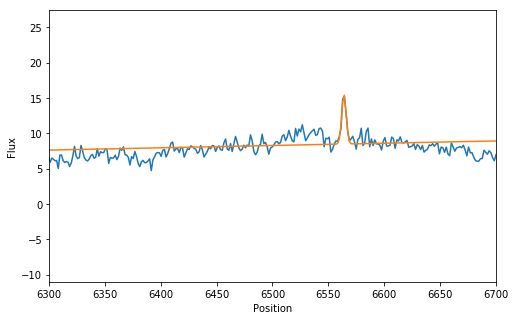

In [17]:
plt.figure(figsize=(8,5))
plt.plot(lam, flux)
plt.plot(lam, gg_fit(lam))
plt.xlim(6300,6700)
plt.xlabel('Position')
plt.ylabel('Flux')

It works! Let's take a look to the fit we just made. 

In [14]:
print(gg_fit)

Model: CompoundModel1
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=1., mean=6563., stddev=10.)>

    [1]: <Polynomial1D(1, c0=0., c1=0.)>
Parameters:
       amplitude_0           mean_0       ...         c1_1        
    ------------------ ------------------ ... --------------------
    7.0208917442781855 6564.1363171493185 ... 0.003239952053005842


We can see that the result includes all the parameter to fit from a gaussian (mean, std and amplitude) and the two coefficients from the polynomial of degree $1$. So now if we want the amplitud of the line we could do:

In [18]:
gg_fit.amplitude_0

Parameter('amplitude_0', value=7.0208917442781855)

## Custom model

What would happend in the case you need a model that `astropy.modeling` doesn't provide? To solve that problem, astropy has another tool called [custom model](http://docs.astropy.org/en/stable/modeling/new.html). Using this tool, we can create any model we want. 

There are two ways we can create a custom model: 
* [basic](http://docs.astropy.org/en/stable/modeling/new.html#basic-custom-models)  
* [full](http://docs.astropy.org/en/stable/modeling/new.html#a-step-by-step-definition-of-a-1-d-gaussian-model). 

We would use the basic one when we need just a simple function to fit and the full when we have a more complex function. Let's use an example to understand each one of the custom models.

## Basic costum model

One example of simple model is an exponential data set. 

In [88]:
x = np.linspace(0,10,100)
y = 3 * np.exp(-2 * x)

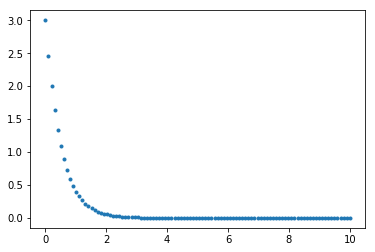

In [84]:
plt.plot(x,y,'.')
plt.show()

We can define a simple costume model in the following way specifying which parameters we want to fit.

In [89]:
@custom_model
def exponential(x, a=1., b=1., c=1.):
    '''
    f(x)=a*exp(b*x + c)
    '''
    return a*np.exp(b*x+c)

Now we have one more available model to use in the same way we always fit data, but this time, we are going to use the model we defined.

In [90]:
exp_model = exponential()  
fitter = fitting.LevMarLSQFitter()
exp_fit = fitter(exp_model, x, y)

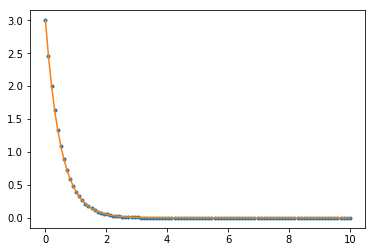

In [91]:
plt.plot(x,y,'.')
plt.plot(x,exp_fit(x))
plt.show()

Great!

## Full costum model

What if now we add noise to the exponential data?

In [139]:
x = np.linspace(0,10,100)
y = 3 * np.exp(-2 * x)
y += np.random.normal(0., 0.2, x.shape)

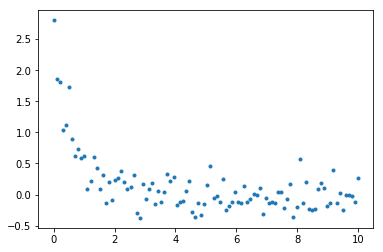

In [140]:
plt.plot(x,y,'.')
plt.show()

Let's use the exponential model we just created to fit the data.

In [159]:
exp_model = exponential()  
fitter = fitting.LevMarLSQFitter()
exp_fit = fitter(exp_model, x, y)

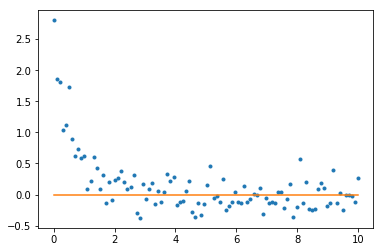

In [160]:
plt.plot(x,y,'.')
plt.plot(x,exp_fit(x))
plt.show()

Not working.

Let's define a full model. In this case we can set the derivative of the function that is going to be useful for the fitter. 

In [156]:
class exponential_full(Fittable1DModel):
    a = Parameter()
    b = Parameter()
    c = Parameter()
        
    @staticmethod
    def evaluate(x, a, b, c):
        return a*np.exp(b*x+c)
    
    @staticmethod
    def fit_deriv(x, a, b, c):
        d_a = np.exp(b*x+c)
        d_b = a*np.exp(b*x+c)*x
        d_c = a*np.exp(b*x+c)
        return [d_a, d_b, d_c]

This time, let's define initial values for the parameters of the fit too.

In [152]:
exp_model_full = exponential_full(a=1.,b=-1.,c=0)  
fitter = fitting.LevMarLSQFitter()
exp_fit_full = fitter(exp_model_full, x, y)

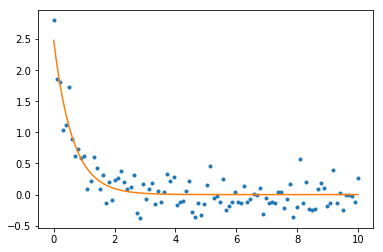

In [153]:
plt.plot(x,y,'.')
plt.plot(x,exp_fit_full(x))
plt.show()

## Excersice:

Create a costum model to fit the following data.

In [135]:
x = np.linspace(-2,3,100)
y = x**2* np.exp(-0.5 * (x)**3 / 2**2)
y += np.random.normal(0., 0.5, x.shape)

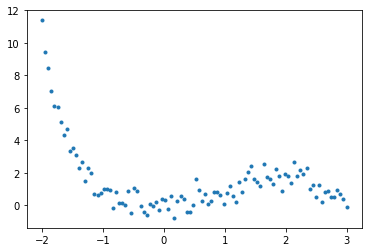

In [136]:
plt.plot(x,y,'.')
plt.show()